## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Read Dataset

In [ ]:
dataset = pd.read_excel('./XAU_USD Historical Data.xlsx')
dataset

,Day,Price
0,2018-10-26,1233.59
1,2018-10-29,1229.74
2,2018-10-30,1223.44
3,2018-10-31,1214.54
4,2018-11-01,1233.24
...,...,...
1318,2023-11-20,1977.19
1319,2023-11-21,1998.37
1320,2023-11-22,1989.72
1321,2023-11-23,1991.79


In [ ]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Day     1323 non-null   datetime64[ns]
 1   Price   1323 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.8 KB
None


In [ ]:
dataset.describe()

,Price
count,1323.000000
mean,1718.505329
std,220.245644
min,1200.650000
25%,1565.795000
50%,1787.440000
75%,1884.200000
max,2063.810000


<Axes: xlabel='Day', ylabel='Price'>

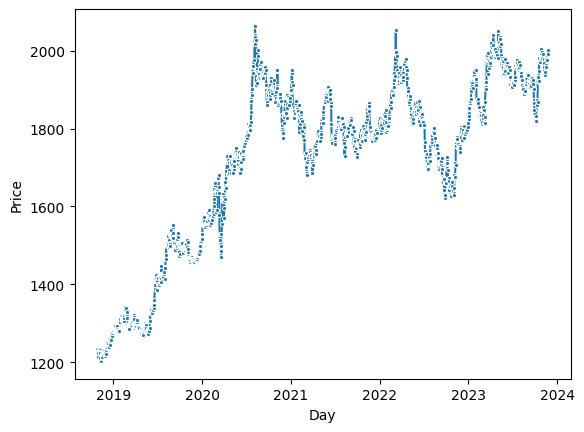

In [ ]:
sns.lineplot(x="Day", y="Price",
             data=dataset, marker='.')

In [ ]:
import plotly.express as px

df = dataset.set_index('Day').rename_axis('features', axis=1)
fig = px.area(df, facet_col='features', facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

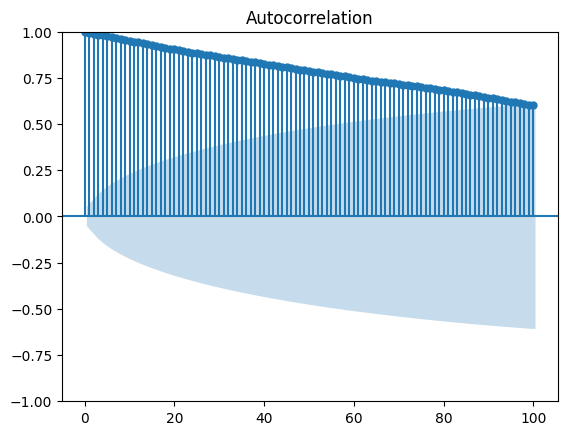

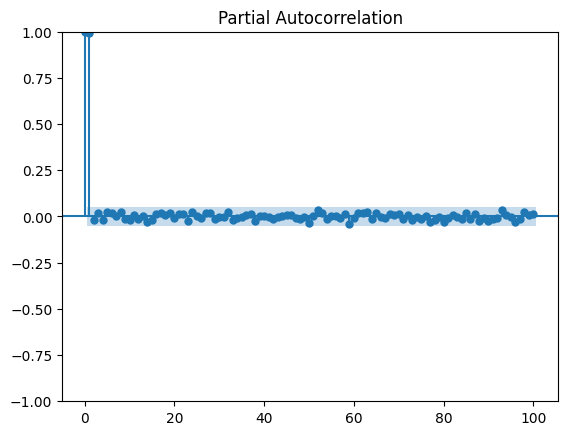

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

acf_plot = plot_acf(dataset.Price, lags=100) #dies down
pacf_plot = plot_pacf(dataset.Price, lags=100)

Based on decaying ACF, we are likely dealing with an Auto Regressive process

Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 8, 13

## ADF Test for Stationarity
The ADF test is one of the most popular statistical tests. It can be used to help us understand whether the time series is stationary or not.

Null hypothesis: If failed to be rejected, it suggests the time series is not stationarity.

Alternative hypothesis: The null hypothesis is rejected, it suggests the time series is stationary.


In [ ]:
n_obs = 6
df_train, df_test = df[0:-n_obs], df[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print('ADF Test: Price time series')
adf_test(df_train)

ADF Test: Price time series
ADF Statistics: -1.967296
p-value: 0.301094
Critical values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


The p-values are all well above the 0.05 alpha level, we cannot reject the null hypothesis. So the three time series are not stationary.

## KPSS Test for Stationary
The KPSS test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root.

Null hypothesis: The time series is stationary

Alternative hypothesis: The time series is not stationary

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(data):
    statistic, p_value, n_lags, critical_values = kpss(data.values)

    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

print('KPSS Test: Price time series')
kpss_test(df_train)

KPSS Test: Price time series
KPSS Statistic: 4.081011780674278
p-value: 0.01
num lags: 21
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


<ipython-input-364-87c9b14875ec>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The p-value are all less than 0.05 alpha level, therefore, we can reject the null hypothesis and derive that the three time series are not stationary.

After cross-check ADF test and KPSS test. We can conclude that the three time series data we have here are not stationary. We will transform the time series to be stationary by difference method.

## Differencing Method

In [ ]:
df_train_transformed = df_train.diff().dropna()

fig = px.line(df_train_transformed, facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

## ADF Test Again

In [ ]:
print('ADF Test: Price time series transformed')
adf_test(df_train_transformed)

ADF Test: Price time series transformed
ADF Statistics: -26.360200
p-value: 0.000000
Critical values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


After transforming the data, the p-values are all well below the 0.05 alpha level, therefore, we reject the null hypothesis. So the current data is stationary.

## KPSS Test Again

In [ ]:
print('KPSS Test: Price time series transformed')
kpss_test(df_train_transformed)

KPSS Test: Price time series transformed
KPSS Statistic: 0.09026698578168006
p-value: 0.1
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


<ipython-input-364-87c9b14875ec>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




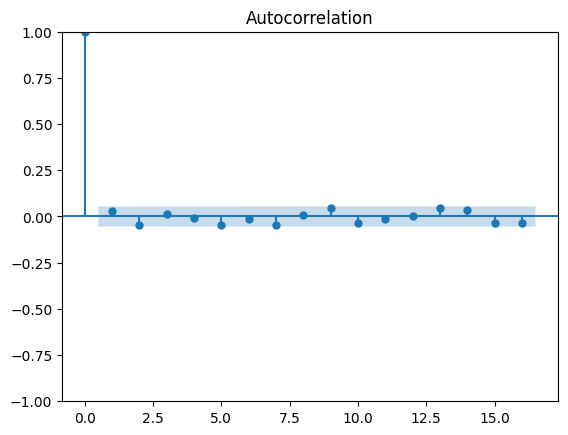

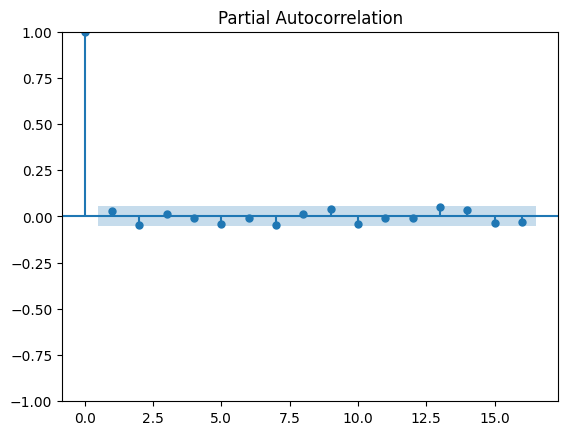

In [ ]:
acf_plot = plot_acf(df_train_transformed.Price, lags=16) #dies down
pacf_plot = plot_pacf(df_train_transformed.Price, lags=16) #dies down

After transforming the data, the p-values are all well above the 0.05 alpha level, therefore, we cannot reject the null hypothesis. So the three time series are stationary.

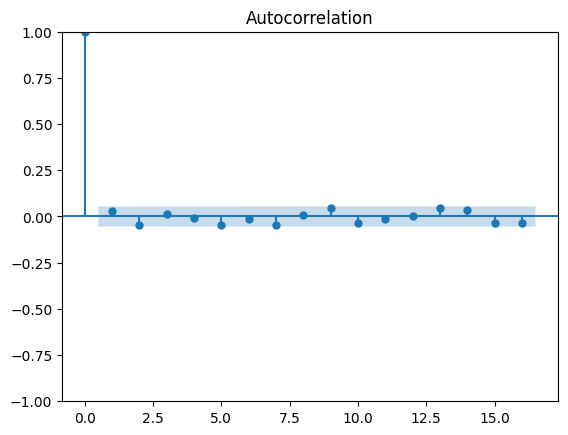

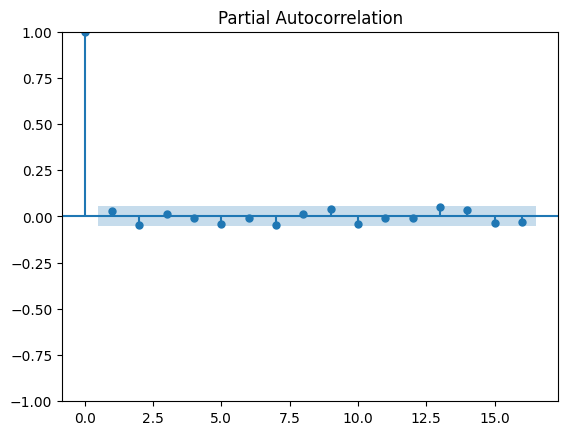

In [ ]:
acf_plot = plot_acf(df_train_transformed.Price, lags=16) #dies down
pacf_plot = plot_pacf(df_train_transformed.Price, lags=16) #dies down

## Split data to valing and testing

In [ ]:
df_train_transformed

features,Price
Day,
2018-10-29,-3.85
2018-10-30,-6.30
2018-10-31,-8.90
2018-11-01,18.70
2018-11-02,-0.35
...,...
2023-11-10,-21.40
2023-11-13,9.10
2023-11-14,16.78


In [ ]:
n_lookback = 1  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

In [ ]:
data_train = df_train_transformed[:-n_forecast]['Price']
data_train = pd.DataFrame(data_train)
data_train.index = df_train_transformed[:-n_forecast].index

data_test = df_train_transformed[-n_forecast:]['Price']
data_test = pd.DataFrame(data_test)
data_test.index = df_train_transformed[-n_forecast:].index

print('shape of training data: ',data_train.shape);print('shape of testing data: ',data_test.shape)

shape of training data:  (1286, 1)
shape of testing data:  (30, 1)


In [ ]:
data_test.head()

,Price
Day,
2023-10-06,12.25
2023-10-09,28.62
2023-10-10,-0.79
2023-10-11,13.52
2023-10-12,-4.96


In [ ]:
Price = data_train["Price"]
Price = Price.values.reshape(-1, 1)

In [ ]:
# Splits the data into training and validation sets.
SPLIT_TIME = int(len(data_train) * 0.7)
Price_train = Price[:SPLIT_TIME]
Price_val = Price[SPLIT_TIME:]
print(Price_train.shape);print(Price_val.shape)

(900, 1)
(386, 1)


In [ ]:
x_train = []
y_train = []

for i in range(n_lookback, len(Price_train) - n_forecast + 1):
    x_train.append(Price_train[i - n_lookback: i])
    y_train.append(Price_train[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(870, 1, 1)
(870, 30, 1)


In [ ]:
print(x_train[0]);print(y_train[0])

[[-3.85]]
[[ -6.3 ]
 [ -8.9 ]
 [ 18.7 ]
 [ -0.35]
 [ -1.59]
 [ -4.5 ]
 [ -0.69]
 [ -2.57]
 [-13.94]
 [ -8.95]
 [  1.7 ]
 [  8.56]
 [  2.09]
 [  8.47]
 [  2.58]
 [ -2.5 ]
 [  4.47]
 [  1.43]
 [ -4.26]
 [ -0.82]
 [ -7.68]
 [  6.42]
 [  2.88]
 [ -2.02]
 [  9.11]
 [  7.47]
 [ -0.99]
 [  0.43]
 [ 10.11]
 [ -3.51]]


In [ ]:
x_val = []
y_val = []

for i in range(n_lookback, len(Price_val) - n_forecast + 1):
    x_val.append(Price_val[i - n_lookback: i])
    y_val.append(Price_val[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(356, 1, 1)
(356, 30, 1)


In [ ]:
print(x_val[-1]);print(y_val[-1])

[[2.29]]
[[ -2.07]
 [  5.13]
 [ 17.46]
 [  5.12]
 [ -2.5 ]
 [ -0.94]
 [ -0.61]
 [-12.38]
 [ -9.53]
 [  2.91]
 [ -1.38]
 [  3.85]
 [ -8.4 ]
 [ -6.96]
 [  4.02]
 [ 13.25]
 [  9.57]
 [ -2.2 ]
 [ -1.26]
 [-10.11]
 [  5.42]
 [ -9.33]
 [-15.17]
 [-25.79]
 [-10.14]
 [-16.25]
 [-20.91]
 [ -4.59]
 [ -1.73]
 [ -1.07]]


# Vanilla LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dense

modelVanillaLSTM = Sequential([
        LSTM(16, activation='relu', input_shape=x_train[0].shape, return_sequences=True),
        Flatten(),
        Dense(n_forecast)
    ])

modelVanillaLSTM.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1, 16)             1152      
                                                                 
 flatten_18 (Flatten)        (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 30)                510       
                                                                 
Total params: 1662 (6.49 KB)
Trainable params: 1662 (6.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
modelVanillaLSTM.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=5,
                                          verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=30,verbose=1,
                                       restore_best_weights=True)
# mc=tf.keras.callbacks.ModelCheckpoint('./model/UnivariateForecast_VanillaLSTM-Model.h5', monitor='val_mae', mode='min', verbose=1, save_best_only=True)

In [ ]:
historyVanillaLSTM = modelVanillaLSTM.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=64,
    callbacks=[rlronp, estop],
    validation_data=(x_val,y_val))

Epoch 1/1000
14/14 [==============================] - 2s 26ms/step - loss: 10.7000 - mae: 11.1884 - val_loss: 11.5792 - val_mae: 12.0694 - lr: 1.0000e-04
Epoch 2/1000
14/14 [==============================] - 0s 6ms/step - loss: 10.6991 - mae: 11.1876 - val_loss: 11.5789 - val_mae: 12.0691 - lr: 1.0000e-04
Epoch 3/1000
14/14 [==============================] - 0s 7ms/step - loss: 10.6983 - mae: 11.1867 - val_loss: 11.5786 - val_mae: 12.0689 - lr: 1.0000e-04
Epoch 4/1000
14/14 [==============================] - 0s 6ms/step - loss: 10.6975 - mae: 11.1859 - val_loss: 11.5783 - val_mae: 12.0686 - lr: 1.0000e-04
Epoch 5/1000
14/14 [==============================] - 0s 7ms/step - loss: 10.6968 - mae: 11.1852 - val_loss: 11.5781 - val_mae: 12.0683 - lr: 1.0000e-04
Epoch 6/1000
14/14 [==============================] - 0s 6ms/step - loss: 10.6960 - mae: 11.1844 - val_loss: 11.5778 - val_mae: 12.0681 - lr: 1.0000e-04
Epoch 7/1000
14/14 [==============================] - 0s 7ms/step - loss: 10.6953

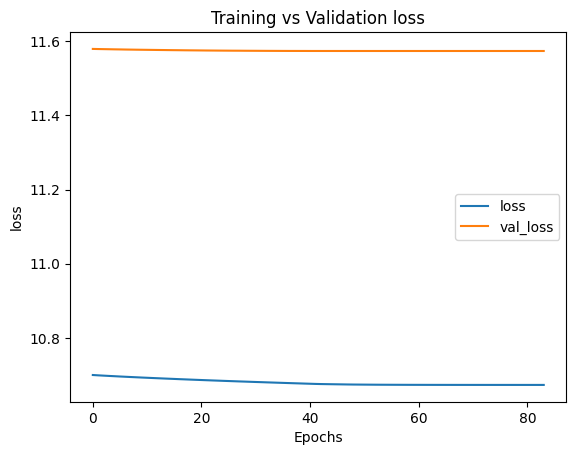

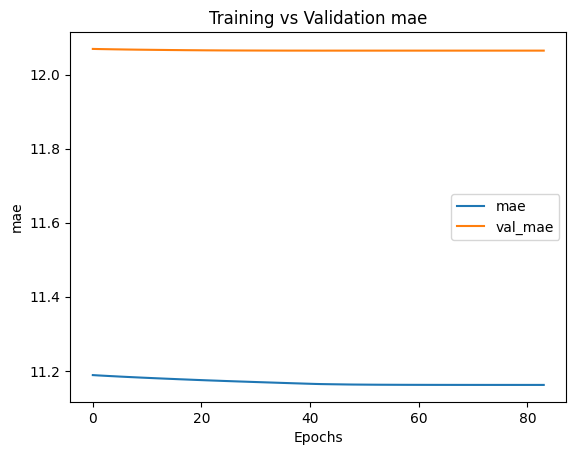

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric}")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(historyVanillaLSTM, "loss")
plot_graphs(historyVanillaLSTM, "mae")

## Prediction with validation data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
rnn_forecast = model_forecast(modelVanillaLSTM, Price_val, n_lookback, 1)
print(rnn_forecast.shape)

rnn_forecast = rnn_forecast[:-1, 0]
print(rnn_forecast.shape)
print(Price_val.shape[0]-n_lookback)

386/386 [==============================] - 1s 2ms/step
(386, 30)
(385,)
385


In [ ]:
# # rnn_forecast2 = scaler.inverse_transform(rnn_forecast2.reshape(-1, 1))
rnn_forecast = rnn_forecast.reshape(-1, 1)
rnn_forecast[:5]

array([[ 0.10476729],
       [-0.03981257],
       [ 0.04522768],
       [ 0.07155745],
       [-0.7774078 ]], dtype=float32)

In [ ]:
actual = np.squeeze(Price_val[-rnn_forecast.shape[0]:])
print(actual.shape)

(385,)


In [ ]:
# actual = scaler.inverse_transform(actual.reshape(-1, 1))
actual[:5]

array([ -4.2 ,   1.02,   3.96, -28.66,   7.57])

In [ ]:
df_ = pd.DataFrame(columns=['Day', 'Actual', 'Forecast'])
df_['Day'] = data_train[-rnn_forecast.shape[0]:].index
df_['Forecast'] = rnn_forecast
df_['Actual'] = actual
df_

,Day,Actual,Forecast
0,2022-04-14,-4.20,0.104767
1,2022-04-15,1.02,-0.039813
2,2022-04-18,3.96,0.045228
3,2022-04-19,-28.66,0.071557
4,2022-04-20,7.57,-0.777408
...,...,...,...
380,2023-09-29,-16.25,-0.170786
381,2023-10-02,-20.91,-0.345041
382,2023-10-03,-4.59,-0.500014
383,2023-10-04,-1.73,-0.047847


<Axes: xlabel='Day', ylabel='Actual'>

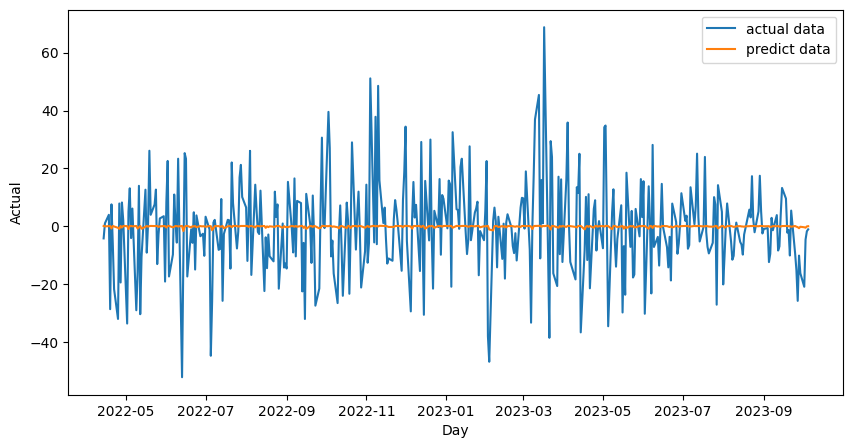

In [ ]:
import seaborn as sns

plt.subplots(figsize=(10, 5))
sns.lineplot(x='Day', y="Actual",
             data=df_, label="actual data")
sns.lineplot(x='Day', y="Forecast",
             data=df_, label="predict data")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(df_['Forecast'], df_['Actual'], squared=False)
mae = mean_absolute_error(df_['Forecast'], df_['Actual'])

print('Forecast accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy
RMSE:  16.01
MAE:  11.97


# Stacked LSTM

### Create Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dense

modelStackedLSTM = Sequential([
        LSTM(32, activation='relu', input_shape=x_train[0].shape, return_sequences=True),
        LSTM(32, activation='relu', return_sequences=True),
        Flatten(),
        Dense(n_forecast)
    ])

modelStackedLSTM.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 1, 32)             4352      
                                                                 
 lstm_32 (LSTM)              (None, 1, 32)             8320      
                                                                 
 flatten_19 (Flatten)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 30)                990       
                                                                 
Total params: 13662 (53.37 KB)
Trainable params: 13662 (53.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
modelStackedLSTM.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=5,
                                          verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=30,verbose=1,
                                       restore_best_weights=True)
# mc=tf.keras.callbacks.ModelCheckpoint('./model/UnivariateForecast_StackedLSTM-Model.h5', monitor='val_mae', mode='min', verbose=1, save_best_only=True)

In [ ]:
historyStackedLSTM = modelStackedLSTM.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=64,
    callbacks=[rlronp, estop],
    validation_data=(x_val,y_val))

Epoch 1/1000
14/14 [==============================] - 4s 61ms/step - loss: 10.6783 - mae: 11.1669 - val_loss: 11.5662 - val_mae: 12.0577 - lr: 1.0000e-04
Epoch 2/1000
14/14 [==============================] - 0s 13ms/step - loss: 10.6780 - mae: 11.1666 - val_loss: 11.5663 - val_mae: 12.0578 - lr: 1.0000e-04
Epoch 3/1000
14/14 [==============================] - 0s 14ms/step - loss: 10.6778 - mae: 11.1664 - val_loss: 11.5663 - val_mae: 12.0578 - lr: 1.0000e-04
Epoch 4/1000
14/14 [==============================] - 0s 13ms/step - loss: 10.6775 - mae: 11.1661 - val_loss: 11.5664 - val_mae: 12.0579 - lr: 1.0000e-04
Epoch 5/1000
14/14 [==============================] - 0s 12ms/step - loss: 10.6772 - mae: 11.1659 - val_loss: 11.5664 - val_mae: 12.0580 - lr: 1.0000e-04
Epoch 6/1000
 9/14 [==================>...........] - ETA: 0s - loss: 10.7686 - mae: 11.2570
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
14/14 [==============================] - 0s 12ms/step - loss:

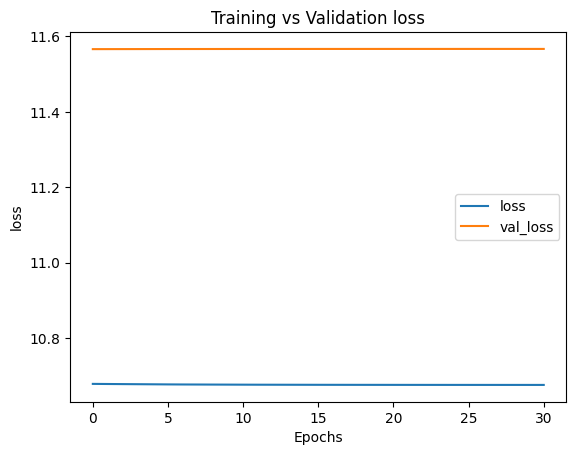

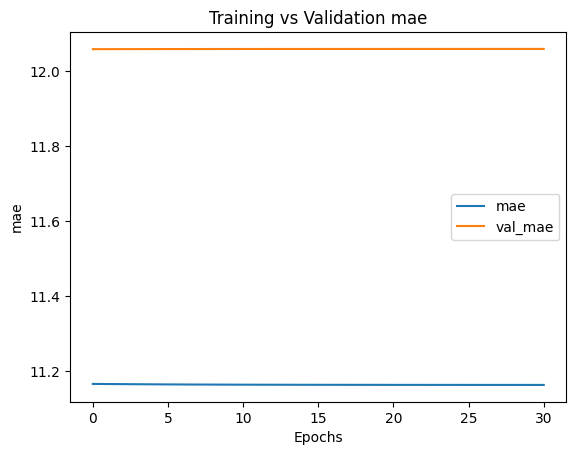

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric}")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(historyStackedLSTM, "loss")
plot_graphs(historyStackedLSTM, "mae")

## Prediction with validation data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
rnn_forecast = model_forecast(modelStackedLSTM, Price_val, n_lookback, 1)
print(rnn_forecast.shape)

rnn_forecast = rnn_forecast[:-1, 0]
print(rnn_forecast.shape)
print(Price_val.shape[0]-n_lookback)

386/386 [==============================] - 1s 2ms/step
(386, 30)
(385,)
385


In [ ]:
# rnn_forecast2 = scaler.inverse_transform(rnn_forecast2.reshape(-1, 1))
rnn_forecast[:5]

array([0.04589647, 0.00875771, 0.00368383, 0.01300473, 0.10704178],
      dtype=float32)

In [ ]:
actual = np.squeeze(Price_val[-rnn_forecast.shape[0]:])
print(actual.shape)

(385,)


In [ ]:
# actual = scaler.inverse_transform(actual.reshape(-1, 1))
actual[:5]

array([ -4.2 ,   1.02,   3.96, -28.66,   7.57])

In [ ]:
df_ = pd.DataFrame(columns=['Day', 'Actual', 'Forecast'])
df_['Day'] = data_train[-rnn_forecast.shape[0]:].index
df_['Forecast'] = rnn_forecast
df_['Actual'] = actual
df_

,Day,Actual,Forecast
0,2022-04-14,-4.20,0.045896
1,2022-04-15,1.02,0.008758
2,2022-04-18,3.96,0.003684
3,2022-04-19,-28.66,0.013005
4,2022-04-20,7.57,0.107042
...,...,...,...
380,2023-09-29,-16.25,0.007706
381,2023-10-02,-20.91,0.017396
382,2023-10-03,-4.59,0.039881
383,2023-10-04,-1.73,0.008993


<Axes: xlabel='Day', ylabel='Actual'>

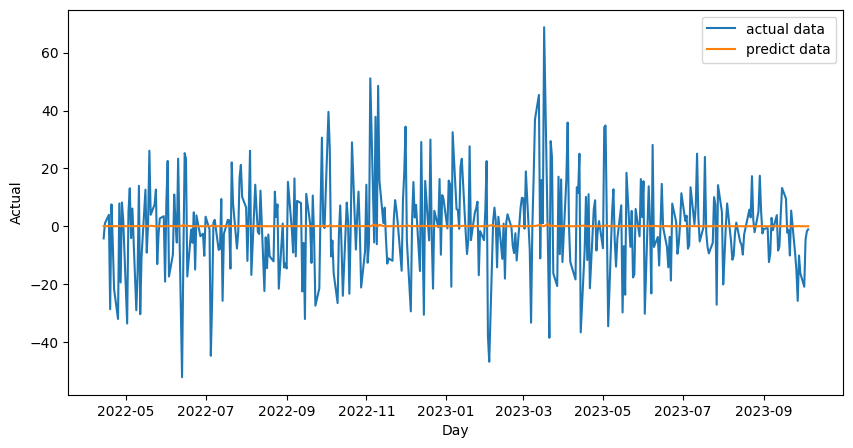

In [ ]:
import seaborn as sns

plt.subplots(figsize=(10, 5))
sns.lineplot(x='Day', y="Actual",
             data=df_, label="actual data")
sns.lineplot(x='Day', y="Forecast",
             data=df_, label="predict data")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(df_['Forecast'], df_['Actual'], squared=False)
mae = mean_absolute_error(df_['Forecast'], df_['Actual'])

print('Forecast accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy
RMSE:  16.01
MAE:  11.97


# Biderectional LSTM

### Create Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense

modelBiLSTM = Sequential([
        Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
                                          input_shape=x_train[0].shape),
        Flatten(),
        Dense(n_forecast)
    ])

modelBiLSTM.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirect  (None, 1, 64)             8704      
 ional)                                                          
                                                                 
 flatten_20 (Flatten)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 30)                1950      
                                                                 
Total params: 10654 (41.62 KB)
Trainable params: 10654 (41.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
modelBiLSTM.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=5,
                                          verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=30,verbose=1,
                                       restore_best_weights=True)
# mc=tf.keras.callbacks.ModelCheckpoint('./model/UnivariateForecast_BiLSTM-Model.h5', monitor='val_mae', mode='min', verbose=1, save_best_only=True)

In [ ]:
historyBiLSTM = modelBiLSTM.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=64,
    callbacks=[rlronp, estop],
    validation_data=(x_val,y_val))

Epoch 1/1000
14/14 [==============================] - 5s 61ms/step - loss: 10.6872 - mae: 11.1759 - val_loss: 11.5902 - val_mae: 12.0807 - lr: 1.0000e-04
Epoch 2/1000
14/14 [==============================] - 0s 12ms/step - loss: 10.6859 - mae: 11.1746 - val_loss: 11.5900 - val_mae: 12.0806 - lr: 1.0000e-04
Epoch 3/1000
14/14 [==============================] - 0s 11ms/step - loss: 10.6848 - mae: 11.1735 - val_loss: 11.5899 - val_mae: 12.0805 - lr: 1.0000e-04
Epoch 4/1000
14/14 [==============================] - 0s 8ms/step - loss: 10.6837 - mae: 11.1724 - val_loss: 11.5898 - val_mae: 12.0804 - lr: 1.0000e-04
Epoch 5/1000
14/14 [==============================] - 0s 8ms/step - loss: 10.6826 - mae: 11.1713 - val_loss: 11.5898 - val_mae: 12.0804 - lr: 1.0000e-04
Epoch 6/1000
14/14 [==============================] - 0s 7ms/step - loss: 10.6815 - mae: 11.1703 - val_loss: 11.5896 - val_mae: 12.0802 - lr: 1.0000e-04
Epoch 7/1000
14/14 [==============================] - 0s 8ms/step - loss: 10.68

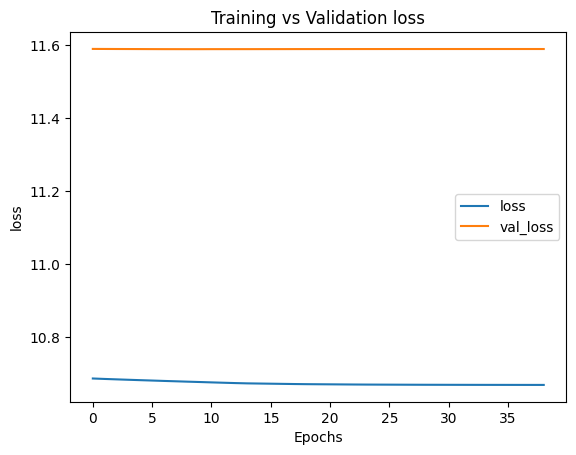

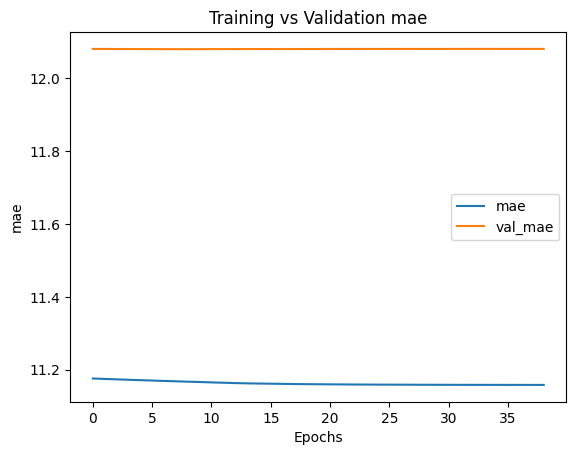

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric}")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(historyBiLSTM, "loss")
plot_graphs(historyBiLSTM, "mae")

## Prediction with validation data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
rnn_forecast = model_forecast(modelBiLSTM, Price_val, n_lookback, 1)
print(rnn_forecast.shape)

rnn_forecast = rnn_forecast[:-1, 0]
print(rnn_forecast.shape)
print(Price_val.shape[0]-n_lookback)

386/386 [==============================] - 1s 3ms/step
(386, 30)
(385,)
385


In [ ]:
# rnn_forecast2 = scaler.inverse_transform(rnn_forecast2.reshape(-1, 1))
rnn_forecast[:5]

array([ 0.15693226, -0.13174316,  0.02104899,  0.04959643, -1.6571608 ],
      dtype=float32)

In [ ]:
actual = np.squeeze(Price_val[-rnn_forecast.shape[0]:])
print(actual.shape)

(385,)


In [ ]:
# actual = scaler.inverse_transform(actual.reshape(-1, 1))
actual[:5]

array([ -4.2 ,   1.02,   3.96, -28.66,   7.57])

In [ ]:
df_ = pd.DataFrame(columns=['Day', 'Actual', 'Forecast'])
df_['Day'] = data_train[-rnn_forecast.shape[0]:].index
df_['Forecast'] = rnn_forecast
df_['Actual'] = actual
df_

,Day,Actual,Forecast
0,2022-04-14,-4.20,0.156932
1,2022-04-15,1.02,-0.131743
2,2022-04-18,3.96,0.021049
3,2022-04-19,-28.66,0.049596
4,2022-04-20,7.57,-1.657161
...,...,...,...
380,2023-09-29,-16.25,-0.448760
381,2023-10-02,-20.91,-0.840894
382,2023-10-03,-4.59,-1.147368
383,2023-10-04,-1.73,-0.148754


<Axes: xlabel='Day', ylabel='Actual'>

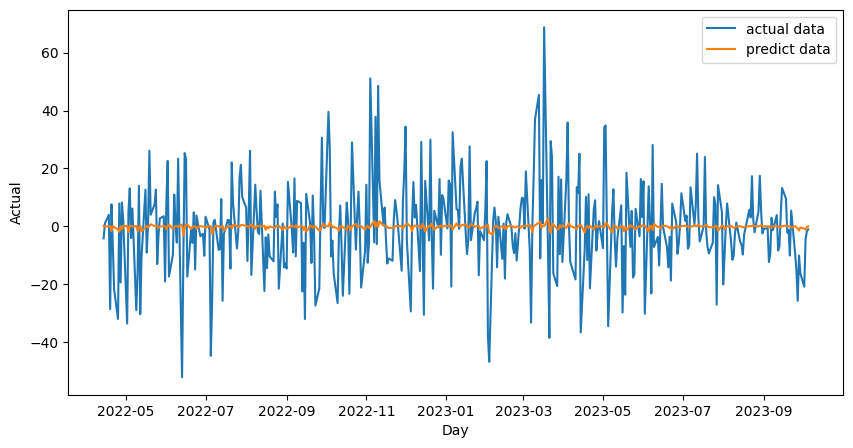

In [ ]:
import seaborn as sns

plt.subplots(figsize=(10, 5))
sns.lineplot(x='Day', y="Actual",
             data=df_, label="actual data")
sns.lineplot(x='Day', y="Forecast",
             data=df_, label="predict data")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(df_['Forecast'], df_['Actual'], squared=False)
mae = mean_absolute_error(df_['Forecast'], df_['Actual'])

print('Forecast accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy
RMSE:  16.01
MAE:  12.01


# Dense-BiLSTM

### Create Model

In [ ]:
modelDenseBiLSTM = tf.keras.Sequential([
        tf.keras.layers.Dense(
            64,
            input_shape=x_train[0].shape,
            activation="relu"),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_forecast)
    ])

# Code to val and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)# YOUR CODE HERE
modelDenseBiLSTM.compile(loss=tf.losses.Huber(),
                  optimizer=optimizer,
                  metrics=['mae'])

modelDenseBiLSTM.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 1, 64)             128       
                                                                 
 bidirectional_22 (Bidirect  (None, 1, 64)             24832     
 ional)                                                          
                                                                 
 dropout_3 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten_21 (Flatten)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 30)                1950      
                                                                 
Total params: 26910 (105.12 KB)
Trainable params: 26910 (105.12 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
modelDenseBiLSTM.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=5,
                                          verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=30,verbose=1,
                                       restore_best_weights=True)
# mc=tf.keras.callbacks.ModelCheckpoint('./model/UnivariateForecast_DenseBiLSTM-Model.h5', monitor='val_mae', mode='min', verbose=1, save_best_only=True)

In [ ]:
historyDenseBiLSTM = modelDenseBiLSTM.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=64,
    callbacks=[rlronp, estop],
    validation_data=(x_val,y_val))

Epoch 1/1000
14/14 [==============================] - 5s 80ms/step - loss: 10.6796 - mae: 11.1680 - val_loss: 11.5673 - val_mae: 12.0587 - lr: 1.0000e-04
Epoch 2/1000
14/14 [==============================] - 0s 9ms/step - loss: 10.6774 - mae: 11.1660 - val_loss: 11.5674 - val_mae: 12.0588 - lr: 1.0000e-04
Epoch 3/1000
14/14 [==============================] - 0s 11ms/step - loss: 10.6756 - mae: 11.1641 - val_loss: 11.5676 - val_mae: 12.0590 - lr: 1.0000e-04
Epoch 4/1000
14/14 [==============================] - 0s 9ms/step - loss: 10.6733 - mae: 11.1620 - val_loss: 11.5677 - val_mae: 12.0592 - lr: 1.0000e-04
Epoch 5/1000
14/14 [==============================] - 0s 10ms/step - loss: 10.6732 - mae: 11.1617 - val_loss: 11.5679 - val_mae: 12.0594 - lr: 1.0000e-04
Epoch 6/1000
10/14 [====================>.........] - ETA: 0s - loss: 10.6962 - mae: 11.1849
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
14/14 [==============================] - 0s 10ms/step - loss: 1

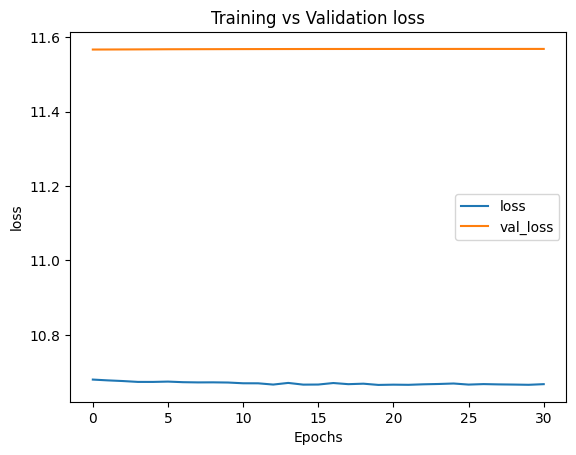

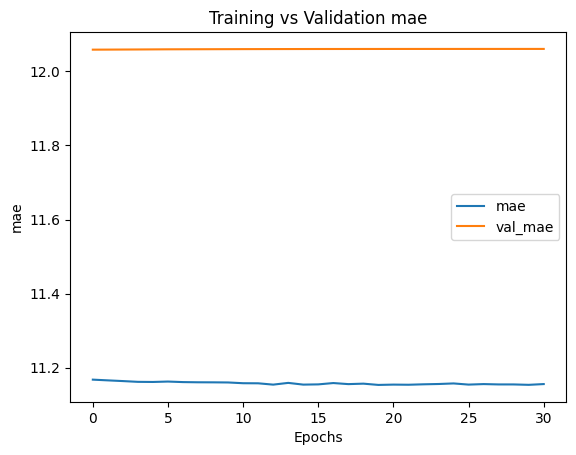

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric}")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(historyDenseBiLSTM, "loss")
plot_graphs(historyDenseBiLSTM, "mae")

## Prediction with validation data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
rnn_forecast = model_forecast(modelDenseBiLSTM, Price_val, n_lookback, 1)
print(rnn_forecast.shape)

rnn_forecast = rnn_forecast[:-1, 0]
print(rnn_forecast.shape)
print(Price_val.shape[0]-n_lookback)

386/386 [==============================] - 2s 2ms/step
(386, 30)
(385,)
385


In [ ]:
# rnn_forecast2 = scaler.inverse_transform(rnn_forecast2.reshape(-1, 1))
rnn_forecast[:5]

array([-0.13447312,  0.03451444, -0.01003633, -0.05944632, -0.08214767],
      dtype=float32)

In [ ]:
actual = np.squeeze(Price_val[-rnn_forecast.shape[0]:])
print(actual.shape)

(385,)


In [ ]:
# actual = scaler.inverse_transform(actual.reshape(-1, 1))
actual[:5]

array([ -4.2 ,   1.02,   3.96, -28.66,   7.57])

In [ ]:
df_ = pd.DataFrame(columns=['Day', 'Actual', 'Forecast'])
df_['Day'] = data_train[-rnn_forecast.shape[0]:].index
df_['Forecast'] = rnn_forecast
df_['Actual'] = actual
df_

,Day,Actual,Forecast
0,2022-04-14,-4.20,-0.134473
1,2022-04-15,1.02,0.034514
2,2022-04-18,3.96,-0.010036
3,2022-04-19,-28.66,-0.059446
4,2022-04-20,7.57,-0.082148
...,...,...,...
380,2023-09-29,-16.25,0.026747
381,2023-10-02,-20.91,-0.014891
382,2023-10-03,-4.59,-0.045822
383,2023-10-04,-1.73,0.036161


<Axes: xlabel='Day', ylabel='Actual'>

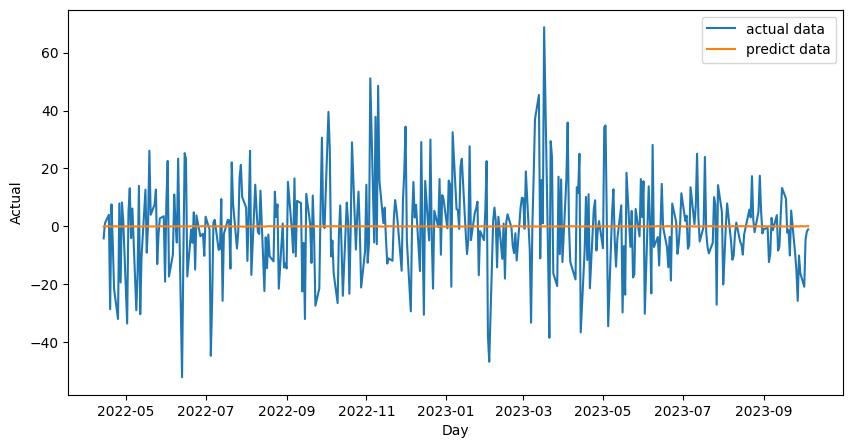

In [ ]:
import seaborn as sns

plt.subplots(figsize=(10, 5))
sns.lineplot(x='Day', y="Actual",
             data=df_, label="actual data")
sns.lineplot(x='Day', y="Forecast",
             data=df_, label="predict data")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(df_['Forecast'], df_['Actual'], squared=False)
mae = mean_absolute_error(df_['Forecast'], df_['Actual'])

print('Forecast accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy
RMSE:  16.0
MAE:  11.96


# 2 Stacked Biderectional LSTM

### Create Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense

model2StackedBiLSTM = Sequential([
        Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
                                          input_shape=x_train[0].shape),
        Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)),
        Flatten(),
        Dense(n_forecast)
    ])

model2StackedBiLSTM.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_23 (Bidirect  (None, 1, 64)             8704      
 ional)                                                          
                                                                 
 bidirectional_24 (Bidirect  (None, 1, 64)             24832     
 ional)                                                          
                                                                 
 flatten_22 (Flatten)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 30)                1950      
                                                                 
Total params: 35486 (138.62 KB)
Trainable params: 35486 (138.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model2StackedBiLSTM.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=5,
                                          verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=20,verbose=1,
                                       restore_best_weights=True)
# mc=tf.keras.callbacks.ModelCheckpoint('./model/UnivariateForecast_2StackedBiLSTM-Model.h5', monitor='val_mae', mode='min', verbose=1, save_best_only=True)

In [ ]:
history2StackedBiLSTM = model2StackedBiLSTM.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=32,
    callbacks=[rlronp, estop],
    validation_data=(x_val,y_val))

Epoch 1/1000
28/28 [==============================] - 7s 53ms/step - loss: 10.6777 - mae: 11.1663 - val_loss: 11.5667 - val_mae: 12.0583 - lr: 1.0000e-04
Epoch 2/1000
28/28 [==============================] - 0s 15ms/step - loss: 10.6770 - mae: 11.1656 - val_loss: 11.5669 - val_mae: 12.0585 - lr: 1.0000e-04
Epoch 3/1000
28/28 [==============================] - 0s 14ms/step - loss: 10.6763 - mae: 11.1649 - val_loss: 11.5670 - val_mae: 12.0587 - lr: 1.0000e-04
Epoch 4/1000
28/28 [==============================] - 0s 13ms/step - loss: 10.6756 - mae: 11.1643 - val_loss: 11.5672 - val_mae: 12.0589 - lr: 1.0000e-04
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 10.6749 - mae: 11.1635 - val_loss: 11.5674 - val_mae: 12.0591 - lr: 1.0000e-04
Epoch 6/1000
20/28 [====================>.........] - ETA: 0s - loss: 10.4445 - mae: 10.9332
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
28/28 [==============================] - 0s 9ms/step - loss: 

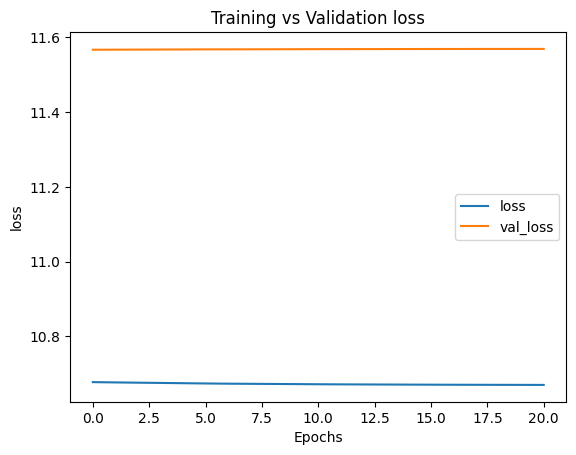

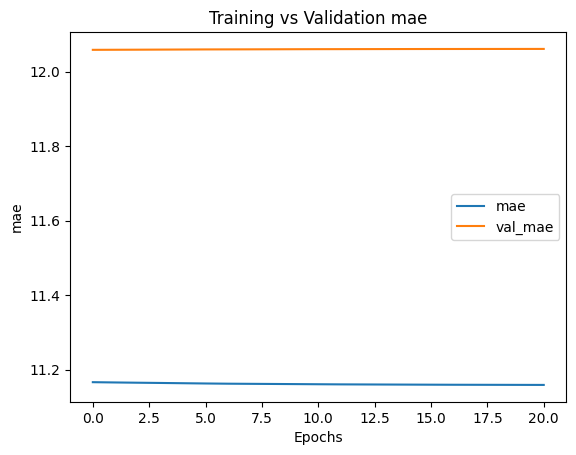

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric}")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history2StackedBiLSTM, "loss")
plot_graphs(history2StackedBiLSTM, "mae")

## Prediction with validation data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
rnn_forecast = model_forecast(model2StackedBiLSTM, Price_val, n_lookback, 1)
print(rnn_forecast.shape)

rnn_forecast = rnn_forecast[:-1, 0]
print(rnn_forecast.shape)
print(Price_val.shape[0]-n_lookback)

386/386 [==============================] - 1s 2ms/step
(386, 30)
(385,)
385


In [ ]:
# rnn_forecast2 = scaler.inverse_transform(rnn_forecast2.reshape(-1, 1))
rnn_forecast[:5]

array([-0.0207183 ,  0.03015179, -0.00091137, -0.00795864,  0.31427488],
      dtype=float32)

In [ ]:
actual = np.squeeze(Price_val[-rnn_forecast.shape[0]:])
print(actual.shape)

(385,)


In [ ]:
# actual = scaler.inverse_transform(actual.reshape(-1, 1))
actual[:5]

array([ -4.2 ,   1.02,   3.96, -28.66,   7.57])

In [ ]:
df_ = pd.DataFrame(columns=['Day', 'Actual', 'Forecast'])
df_['Day'] = data_train[-rnn_forecast.shape[0]:].index
df_['Forecast'] = rnn_forecast
df_['Actual'] = actual
df_

,Day,Actual,Forecast
0,2022-04-14,-4.20,-0.020718
1,2022-04-15,1.02,0.030152
2,2022-04-18,3.96,-0.000911
3,2022-04-19,-28.66,-0.007959
4,2022-04-20,7.57,0.314275
...,...,...,...
380,2023-09-29,-16.25,0.097936
381,2023-10-02,-20.91,0.169352
382,2023-10-03,-4.59,0.224107
383,2023-10-04,-1.73,0.033899


<Axes: xlabel='Day', ylabel='Actual'>

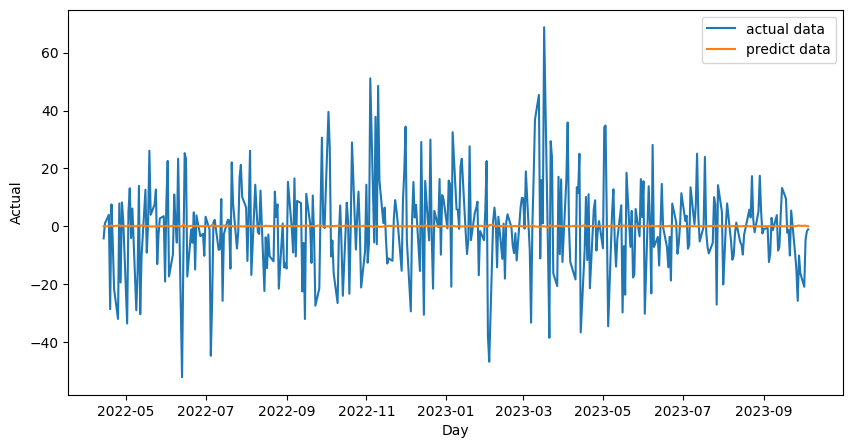

In [ ]:
import seaborn as sns

plt.subplots(figsize=(10, 5))
sns.lineplot(x='Day', y="Actual",
             data=df_, label="actual data")
sns.lineplot(x='Day', y="Forecast",
             data=df_, label="predict data")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(df_['Forecast'], df_['Actual'], squared=False)
mae = mean_absolute_error(df_['Forecast'], df_['Actual'])

print('Forecast accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy
RMSE:  16.01
MAE:  11.96


# 3 Stacked Biderectional LSTM

### Generate 3 Stacked BiLSTM model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense

model3StackedBiLSTM = Sequential([
        Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
                                          input_shape=x_train[0].shape),
        Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)),
        Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)),
        Flatten(),
        Dense(n_forecast)
    ])

model3StackedBiLSTM.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_25 (Bidirect  (None, 1, 64)             8704      
 ional)                                                          
                                                                 
 bidirectional_26 (Bidirect  (None, 1, 64)             24832     
 ional)                                                          
                                                                 
 bidirectional_27 (Bidirect  (None, 1, 64)             24832     
 ional)                                                          
                                                                 
 flatten_23 (Flatten)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 30)                1950      
                                                     

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model3StackedBiLSTM.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=5,
                                          verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=20,verbose=1,
                                       restore_best_weights=True)
# mc=tf.keras.callbacks.ModelCheckpoint('./model/UnivariateForecast_3StackedBiLSTM-Model.h5', monitor='val_mae', mode='min', verbose=1, save_best_only=True)

In [ ]:
history3StackedBiLSTM = model3StackedBiLSTM.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=32,
    callbacks=[rlronp, estop],
    validation_data=(x_val,y_val))

Epoch 1/1000
28/28 [==============================] - 10s 46ms/step - loss: 10.6777 - mae: 11.1663 - val_loss: 11.5660 - val_mae: 12.0575 - lr: 1.0000e-04
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 10.6774 - mae: 11.1660 - val_loss: 11.5660 - val_mae: 12.0576 - lr: 1.0000e-04
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 10.6771 - mae: 11.1657 - val_loss: 11.5660 - val_mae: 12.0576 - lr: 1.0000e-04
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 10.6768 - mae: 11.1654 - val_loss: 11.5661 - val_mae: 12.0577 - lr: 1.0000e-04
Epoch 5/1000
28/28 [==============================] - 0s 13ms/step - loss: 10.6765 - mae: 11.1651 - val_loss: 11.5661 - val_mae: 12.0577 - lr: 1.0000e-04
Epoch 6/1000
26/28 [==========================>...] - ETA: 0s - loss: 10.6103 - mae: 11.0990
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
28/28 [==============================] - 0s 12ms/step - loss

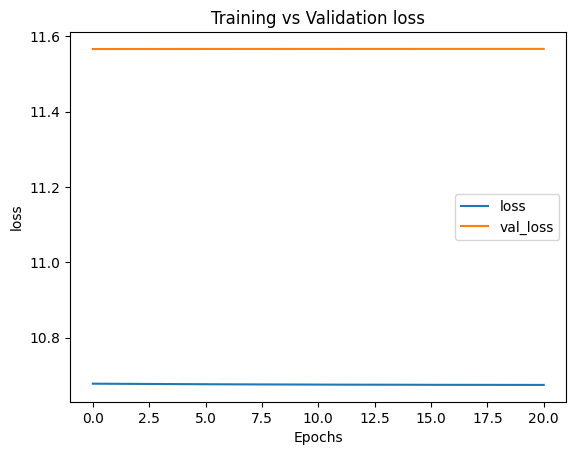

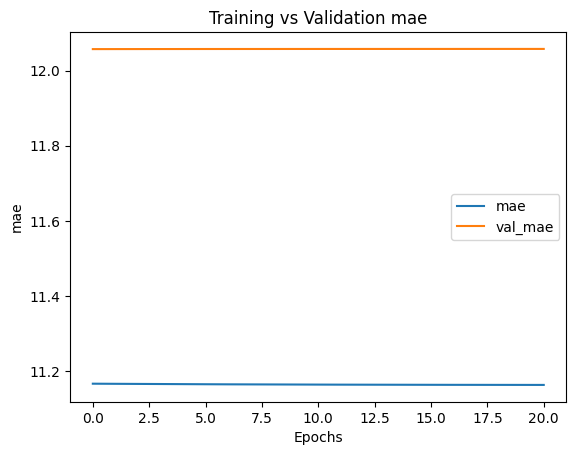

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric}")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history3StackedBiLSTM, "loss")
plot_graphs(history3StackedBiLSTM, "mae")

## Prediction with validation data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
rnn_forecast = model_forecast(model3StackedBiLSTM, Price_val, n_lookback, 1)
print(rnn_forecast.shape)

rnn_forecast = rnn_forecast[:-1, 0]
print(rnn_forecast.shape)
print(Price_val.shape[0]-n_lookback)

386/386 [==============================] - 2s 3ms/step
(386, 30)
(385,)
385


In [ ]:
# rnn_forecast2 = scaler.inverse_transform(rnn_forecast2.reshape(-1, 1))
rnn_forecast[:5]

array([ 0.00063919, -0.00228254,  0.00195404,  0.0012559 , -0.08068836],
      dtype=float32)

In [ ]:
actual = np.squeeze(Price_val[-rnn_forecast.shape[0]:])
print(actual.shape)

(385,)


In [ ]:
# actual = scaler.inverse_transform(actual.reshape(-1, 1))
actual[:5]

array([ -4.2 ,   1.02,   3.96, -28.66,   7.57])

In [ ]:
df_ = pd.DataFrame(columns=['Day', 'Actual', 'Forecast'])
df_['Day'] = data_train[-rnn_forecast.shape[0]:].index
df_['Forecast'] = rnn_forecast
df_['Actual'] = actual
df_

,Day,Actual,Forecast
0,2022-04-14,-4.20,0.000639
1,2022-04-15,1.02,-0.002283
2,2022-04-18,3.96,0.001954
3,2022-04-19,-28.66,0.001256
4,2022-04-20,7.57,-0.080688
...,...,...,...
380,2023-09-29,-16.25,-0.014947
381,2023-10-02,-20.91,-0.033256
382,2023-10-03,-4.59,-0.050023
383,2023-10-04,-1.73,-0.002933


<Axes: xlabel='Day', ylabel='Actual'>

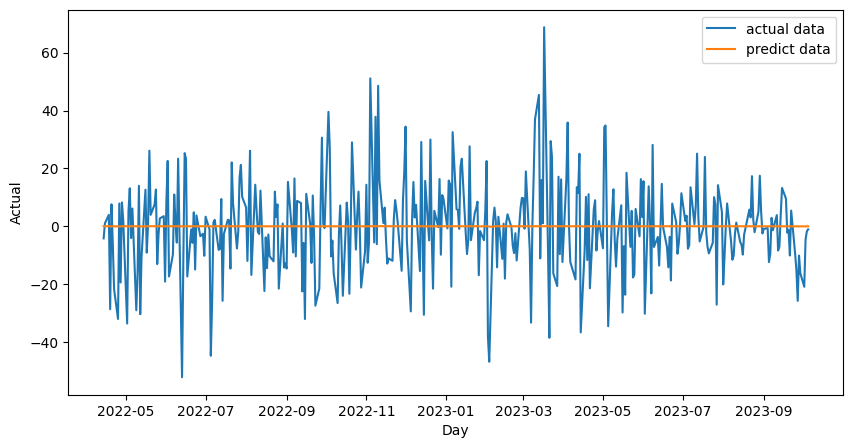

In [ ]:
import seaborn as sns

plt.subplots(figsize=(10, 5))
sns.lineplot(x='Day', y="Actual",
             data=df_, label="actual data")
sns.lineplot(x='Day', y="Forecast",
             data=df_, label="predict data")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = mean_squared_error(df_['Forecast'], df_['Actual'], squared=False)
mae = mean_absolute_error(df_['Forecast'], df_['Actual'])

print('Forecast accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy
RMSE:  16.0
MAE:  11.96
